# IMPORT LIBRARIES

In [1]:
# data manipulation
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
plt.rcParams['figure.figsize'] = 12,6
sns.set_style('darkgrid')
%matplotlib inline

# preprocessing
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate, StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

# metrics
from sklearn.metrics import confusion_matrix, recall_score, precision_score, precision_recall_curve, f1_score, fbeta_score

# hyperparameter tuning
from bayes_opt import BayesianOptimization

# miscellaneous
import math
from time import time

# IMPORT DATASET

In [2]:
df = pd.read_csv('creditcard.csv')
df.head(6)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,-0.371407,1.341262,0.359894,-0.358091,-0.137134,0.517617,0.401726,-0.058133,0.068653,-0.033194,0.084968,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

# CHECK FOR MISSING VALUES

In [4]:
df.isnull().sum() / len(df)

Time      0.0
V1        0.0
V2        0.0
V3        0.0
V4        0.0
V5        0.0
V6        0.0
V7        0.0
V8        0.0
V9        0.0
V10       0.0
V11       0.0
V12       0.0
V13       0.0
V14       0.0
V15       0.0
V16       0.0
V17       0.0
V18       0.0
V19       0.0
V20       0.0
V21       0.0
V22       0.0
V23       0.0
V24       0.0
V25       0.0
V26       0.0
V27       0.0
V28       0.0
Amount    0.0
Class     0.0
dtype: float64

# DISTRIBUTION OF AMOUNT OF FRAUD TRANSACTIONS

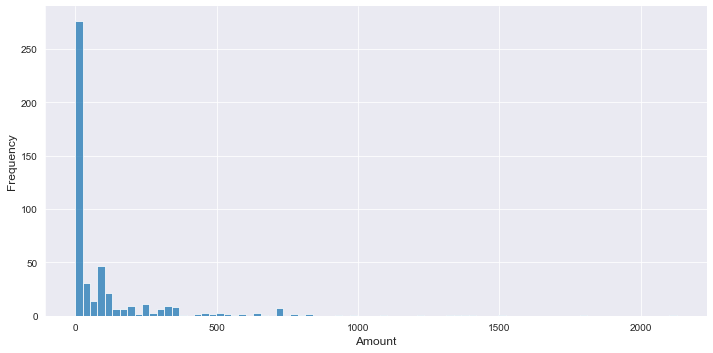

In [5]:
sns.displot(df[df['Class']==1]['Amount'], height=5, aspect=2)
plt.xlabel('Amount', fontsize=12)
plt.ylabel('Frequency', fontsize=12);

In [6]:
fraud_cost = round(df[df['Class']==1]['Amount'].median(), 2)
fraud_cost

9.25

# MODEL DEVELOPMENT

## 1. Model preparation

In [7]:
def create_models():
    models = {}
    models['Logistic Regression'] = LogisticRegression(max_iter=5000)
    models['K-Nearest Neighbors'] = KNeighborsClassifier()
    models['Support Vector Machines'] = SVC()
    models['Decision Tree'] = DecisionTreeClassifier()
    models['Naive Bayes'] = GaussianNB()
    models['Random Forest'] = RandomForestClassifier()
    return models

In [8]:
def evaluate_model(model, X, y, metrics='accuracy'):
    scaler = StandardScaler()
    pipeline = Pipeline(steps=[('scaler', scaler), ('model', model)])
    cv = StratifiedKFold(5, shuffle=True, random_state=143)
    scores = cross_validate(pipeline, X, y, cv=cv, scoring=metrics)
    return scores

In [9]:
def false_positive(estimator, X, y):
    predictions = estimator.predict(X)
    cm = confusion_matrix(y, predictions)
    return cm[0][1]

def false_negative(estimator, X, y):
    predictions = estimator.predict(X)
    cm = confusion_matrix(y, predictions)
    return cm[1][0]

def true_positive(estimator, X, y):
    predictions = estimator.predict(X)
    cm = confusion_matrix(y, predictions)
    return cm[1][1]

def f2_score(estimator, X, y):
    predictions = estimator.predict(X)
    return fbeta_score(y, predictions, beta=2)

In [10]:
df = df.iloc[:,1:]
X = df.drop('Class', axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=143)

## 2. Cross validation

In [11]:
names = []
results = []

scoring = {'fp':false_positive,
           'fn':false_negative,
           'recall': 'recall',
           'precision': 'precision',
           'f1_score': 'f1',
           'f2_score':f2_score}

for name, model in create_models().items():
    print(f'--- Initializing {name} ---')
    scores = evaluate_model(model, X_train, y_train, scoring)
    names.append(name)
    results.append(scores)
    print(f'--- {name} done! ---')

--- Initializing Logistic Regression ---
--- Logistic Regression done! ---
--- Initializing K-Nearest Neighbors ---
--- K-Nearest Neighbors done! ---
--- Initializing Support Vector Machines ---
--- Support Vector Machines done! ---
--- Initializing Decision Tree ---
--- Decision Tree done! ---
--- Initializing Naive Bayes ---
--- Naive Bayes done! ---
--- Initializing Random Forest ---
--- Random Forest done! ---


In [12]:
test_fp = []
test_fn = []
test_recall = []
test_precision = []
test_f1 = []
test_f2 = []
time_taken = []

for i in range(len(results)):
    test_fp.append(round(results[i]['test_fp'].mean()))

for i in range(len(results)):
    test_fn.append(round(results[i]['test_fn'].mean()))

for i in range(len(results)):
    test_recall.append(results[i]['test_recall'].mean())

for i in range(len(results)):
    test_precision.append(results[i]['test_precision'].mean())

for i in range(len(results)):
    test_f1.append(results[i]['test_f1_score'].mean())

for i in range(len(results)):
    test_f2.append(results[i]['test_f2_score'].mean())

for i in range(len(results)):
    time_taken.append(round(results[i]['score_time'].sum(), 1) + round(results[i]['fit_time'].sum(), 1))

test_fn = pd.Series(test_fn, name='False negative')
test_fp = pd.Series(test_fp, name='False positive')
test_recall = pd.Series(test_recall, name='Recall')
test_precision = pd.Series(test_precision, name='Precision')
test_f1 = pd.Series(test_f1, name='F1-score')
test_f2 = pd.Series(test_f2, name='F2-score')
time_taken = pd.Series(time_taken, name='Time to compute (seconds)')

df_result = pd.concat([test_fp, test_fn, test_recall, test_precision, test_f1, test_f2, time_taken], axis=1)
df_result.index = names
df_result['Money loss (RM)'] = round(fraud_cost * df_result['False negative'], 2)
df_result = df_result.iloc[:,[0, 1, 2, 3, 4, 5, 7, 6]]
df_result.sort_values(['F2-score'], ascending=False)

,False positive,False negative,Recall,Precision,F1-score,F2-score,Money loss (RM),Time to compute (seconds)
Random Forest,4,14,0.781212,0.935694,0.850751,0.807474,129.50,698.0
K-Nearest Neighbors,5,15,0.769091,0.919808,0.836921,0.794706,138.75,3560.9
Decision Tree,15,16,0.753939,0.767595,0.759584,0.755924,148.00,71.8
Support Vector Machines,2,23,0.644336,0.946674,0.765423,0.687665,212.75,1309.6
Logistic Regression,6,25,0.620326,0.867202,0.721762,0.657042,231.25,7.6
Naive Bayes,892,10,0.842005,0.058520,0.109428,0.228914,92.50,2.4


## 3. Model training and evaluation

In [13]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [14]:
forest = RandomForestClassifier(random_state=143)
forest.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=143)

In [15]:
predictions = forest.predict(X_test_scaled)
confusion_matrix(y_test, predictions)

array([[85273,     7],
       [   43,   120]], dtype=int64)

In [16]:
fbeta_score(y_test, predictions, beta=2)

0.7702182284980743

In [17]:
(tn, fp), (fn, tp) = confusion_matrix(y_test, predictions)

print(f'Cost: RM {round(fn * fraud_cost, 2)}')

Cost: RM 397.75


## 4. Hyperparameter tuning

In [18]:
def estimator(max_depth, min_samples_split, max_features, n_estimators):
    params = {}
    params['max_depth'] = round(max_depth)
    params['min_samples_split'] = round(min_samples_split)
    params['max_features'] = round(max_features, 1)
    params['n_estimators'] = round(n_estimators)
    
    scaler = StandardScaler()
    cv = StratifiedKFold(5, shuffle=True, random_state=143)
    
    model = RandomForestClassifier(random_state=143, **params)
    pipeline = Pipeline(steps=[('scaler', scaler), ('model', model)])
    
    score = cross_val_score(pipeline, X_train, y_train, scoring='f1', cv=cv).mean()
    return score

params_bounds = {
    'max_depth':(5, 30),
    'min_samples_split':(2, 60),
    'max_features':(0.1, 1.0),
    'n_estimators':(50, 1000),
}

forest_bo = BayesianOptimization(estimator, params_bounds, random_state=143)
forest_bo.maximize(init_points=30, n_iter=5)

|   iter    |  target   | max_depth | max_fe... | min_sa... | n_esti... |
-------------------------------------------------------------------------
|  1        |  0.8353   |  23.44    |  0.406    |  29.15    |  452.7    |
|  2        |  0.8563   |  19.21    |  0.8932   |  3.922    |  58.34    |
|  3        |  0.8141   |  9.981    |  0.2505   |  58.2     |  103.7    |
|  4        |  0.8117   |  7.239    |  0.3517   |  37.34    |  117.0    |
|  5        |  0.8541   |  19.31    |  0.3993   |  17.18    |  138.0    |
|  6        |  0.8369   |  21.55    |  0.1797   |  14.78    |  85.31    |
|  7        |  0.8434   |  9.239    |  0.6577   |  25.08    |  963.9    |
|  8        |  0.8159   |  27.41    |  0.3296   |  49.94    |  839.3    |
|  9        |  0.8338   |  5.048    |  0.6119   |  12.53    |  79.01    |
|  10       |  0.8618   |  25.78    |  0.5386   |  13.83    |  489.9    |
|  11       |  0.8323   |  23.31    |  0.2497   |  19.29    |  809.4    |
|  12       |  0.8671   |  24.69    | 

In [19]:
params_forest = forest_bo.max['params']
params_forest['max_depth'] = round(params_forest['max_depth'])
params_forest['min_samples_split'] = round(params_forest['min_samples_split'])
params_forest['max_features'] = round(params_forest['max_features'], 1)
params_forest['n_estimators'] = round(params_forest['n_estimators'])

In [20]:
params_forest

{'max_depth': 10,
 'max_features': 0.7,
 'min_samples_split': 6,
 'n_estimators': 262}

## 5. Tune the model

In [21]:
forest = RandomForestClassifier(random_state=143, **params_forest)
forest.fit(X_train_scaled, y_train)

RandomForestClassifier(max_depth=10, max_features=0.7, min_samples_split=6,
                       n_estimators=262, random_state=143)

In [22]:
predictions = forest.predict(X_test_scaled)
confusion_matrix(y_test, predictions)

array([[85273,     7],
       [   40,   123]], dtype=int64)

In [23]:
fbeta_score(y_test, predictions, beta=2)

0.7864450127877238

In [24]:
(tn, fp), (fn, tp) = confusion_matrix(y_test, predictions)

print(f'Cost: RM {round(fn * fraud_cost, 2)}')

Cost: RM 370.0


# IMPLEMENTATION OF THRESHOLD ANALYSIS

In [25]:
proba = forest.predict_proba(X_test_scaled)

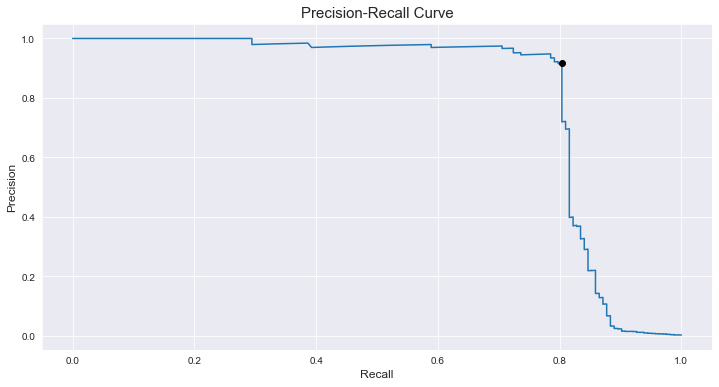

In [26]:
precision, recall, threshold = precision_recall_curve(y_test, proba[:,1])

f2score = (5 * precision * recall) / (4 * precision + recall)
idx = np.argmax(f2score)

plt.figure(figsize=(12,6))
plt.plot(recall, precision)
plt.plot(recall[idx], precision[idx], marker='o', color='black')
plt.title('Precision-Recall Curve', fontsize=15)
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12);

In [27]:
print(f'Threshold: {threshold[idx]}')
print(f'Recall: {recall[idx]:20}')
print(f'Precision: {precision[idx]}')
print(f'F1-score: {f2score[idx]:19}')

Threshold: 0.29377979812347543
Recall:    0.803680981595092
Precision: 0.916083916083916
F1-score:  0.8238993710691823


In [28]:
recall_idx = np.where(recall >= recall_score(y_test, predictions))
recall = recall[recall_idx]
precision = precision[recall_idx]
threshold = threshold[recall_idx]

precision_idx = np.where(precision >= precision_score(y_test, predictions))
recall = recall[precision_idx]
precision = precision[precision_idx]
threshold = threshold[precision_idx]

f2score = (5 * precision * recall) / (4 * precision + recall)
idx = np.argmax(f2score)

In [29]:
print(f'Threshold: {threshold[idx]}')
print(f'Recall: {recall[idx]:21}')
print(f'Precision: {precision[idx]}')
print(f'F1-score: {f2score[idx]:19}')

Threshold: 0.39414758269720096
Recall:    0.7852760736196319
Precision: 0.9481481481481482
F1-score:  0.8132147395171537


In [30]:
new_predictions = np.where(proba[:,1] >= threshold[idx], 1, 0)
confusion_matrix(y_test, new_predictions)

array([[85273,     7],
       [   35,   128]], dtype=int64)

In [31]:
fbeta_score(y_test, new_predictions, beta=2)

0.8132147395171537

In [32]:
(tn, fp), (fn, tp) = confusion_matrix(y_test, new_predictions)

print(f'Cost: RM {round(fn * fraud_cost, 2)}')

Cost: RM 323.75
